# Numerical tests on continuous diagonalization techniques

In [480]:
%matplotlib inline
import numpy as np
import scipy
import scipy.sparse as sparse
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)
import pandas as pd
import itertools as it
import os
import h5py

In [493]:
import scipy
import scipy.sparse as sparse
import scipy.stats
import numpy
import numpy as np
import cmath
import itertools as it


# 1 in up and 0 is down!
class XXZ:
    def __init__(self, L, J, Delta, fields):
        self.L  = L
        self.J  = J
        self.Delta  = Delta
        self.fields = fields
        #print "Got field configuration: " , self.fields

        if len(self.fields) != self.L:
            print "Error: Number of fields must match L!"
            quit()

        self.sectorbasis = {}
        self.state_from_baseidx = {}
        basiscounter= 0
        # Create basis
        for i in xrange(0,2**L):
            self.sectorbasis[i]=basiscounter
            self.state_from_baseidx[basiscounter]=i 
            basiscounter=basiscounter + 1

        self.dim=basiscounter

        self.matrix=None
        self.eigenvalues=None
        self.eigenvectors=None
        
        
    def print_block_basis(self):
        print "Basis:"
        for s in sorted(self.sectorbasis,key=lambda x:self.sectorbasis[x]):
            print(s, self.sectorbasis[s], str('{0:0'+str(self.L)+'b}').format(s))
            
            
    def create_matrix_block(self):
        rowidx=[]
        colidx=[]
        data=[]

        # diagonal part
        for s in self.sectorbasis:
            el=0.0
            for i in xrange(0,self.L):
                sz=float((s&(1<<i))>0)-0.5
                szp1=float((s&(1<<((i+1)%self.L)))>0)-0.5
                el+= self.fields[i]*sz
                ###########FIXME
                if i+1<self.L: ### OBC
                    el+= self.Delta*sz*szp1 ### OBC
                #el+= self.Delta*sz*szp1 ### PBC
                ##END FIXME
            stateidx=self.sectorbasis[s]
            rowidx.append(stateidx)
            colidx.append(stateidx)
            data.append(el)


        # offdiag part
        el = 1./2.0*self.J
        for s in self.sectorbasis:
            stateidx=self.sectorbasis[s]
            ########FIXME
            ##for i in xrange(0,self.L): ### PBC
            for i in xrange(0,self.L-1): ###OBC
                #END FIXME
                #check if i in i+1 bits are different
                if ((s&(1<<i))>0) != ((s&(1<<((i+1)%self.L)))>0):
                    # flip bits
                    s2=(s^( 1<<i ) )^( 1<<((i+1)%self.L))

                    stateidx2=self.sectorbasis[s2]
                    rowidx.append(stateidx)
                    colidx.append(stateidx2)
                    data.append(el)

        self.dim=len(self.sectorbasis)
        self.matrix=scipy.sparse.csr_matrix( (data, (rowidx,colidx)),shape=(self.dim,self.dim))

        # print self.matrix
        
    def diagonalize(self):
        #print "Dense matrix needs ", self.dim**2*8/1024/1024, " MiB of memory."
        self.eigenvalues, self.eigenvectors = numpy.linalg.eigh(self.matrix.todense())
        
        
    # Not checked
    def EE_spectrum(self, eigenvectors, cut):
        dim = eigenvectors.shape[0]
        rhos = self.folded_psi_spectrum(eigenvectors, cut)
        entanglement_spectrum = np.array([self.EE_from_rho(rho) for rho in rhos])
        return entanglement_spectrum
    
    # Not checked
    def folded_psi_spectrum(self, eigenvectors, cut):
        # Only half cut for the moment
        dim = eigenvectors.shape[0]
        dim_A = 2**(cut)
        dim_B = 2**(self.L-cut)
        rhos = np.zeros((dim, dim_A, dim_B))
        for configuration in self.sectorbasis:
            left = configuration % dim_A
            right = (configuration - left) / dim_A
            rhos[:, left, right] = eigenvectors[self.sectorbasis[configuration], :]
        return rhos
    
    # Not checked
    def EE_from_rho(self, rho):
        U, S, V = np.linalg.svd(rho)
        entanglement = sum([-np.log(max(value, 1e-10)**2) * value**2 for value in S])
        return entanglement
    
    # Not checked
    def EE(self, psi, cut):
        rho = self.folded_psi(psi, cut)
        U, S, V = np.linalg.svd(rho)
        entanglement = sum([-np.log(max(value, 1e-10)**2) * value**2 for value in S])
        return (S, entanglement)

    # Not checked
    def folded_psi(self, psi, cut):
        dim_A = 2**(cut)
        dim_B = 2**(self.L-cut)
        rho = np.zeros((dim_A, dim_B))
        for configuration in self.sectorbasis:
            left = configuration % dim_A
            right = (configuration - left) / dim_A
            rho[left, right] = psi[self.sectorbasis[configuration]]
        return rho
    
    
    # Checked
    def sigma_zi(self, i):
        # idx=0 -> z; idx=1 -> +; idx=2 -> -
        # 1 is first row (+1 for sigma_z); 0 is second row (-1 for sigma_z)
        rowidx=[]
        colidx=[]
        data=[]

        # diagonal part
        for s in self.sectorbasis:
            el=(s&(1<<i)>0)*2.-1.
            stateidx=self.sectorbasis[s]
            rowidx.append(stateidx)
            colidx.append(stateidx)
            data.append(el)
            
        return scipy.sparse.csr_matrix( (data, (rowidx,colidx)),shape=(self.dim,self.dim))
    
    
    # Checked
    def sigma_zi_zj(self, i, j):
        return self.sigma_zi(i).dot(self.sigma_zi(j))
    
    # Checked
    def sigma_pi_mj(self, i, j):
        # p goes from 1 to 0
        rowidx=[]
        colidx=[]
        data=[]

        # diagonal part
        for s in self.sectorbasis:
            if ((s&(1<<i))==0) and ((s&(1<<j))>0):
                el=2. #sqrt(2) multiplied per site; 2 sites
                stateidx=self.sectorbasis[s]
                s2 = (s^( 1<<i ) )^( 1<<j )
                stateidx2=self.sectorbasis[s2]
                rowidx.append(stateidx2)
                colidx.append(stateidx)
                data.append(el)

        return scipy.sparse.csr_matrix( (data, (rowidx,colidx)),shape=(self.dim,self.dim))

In [494]:
random_numbers_file = np.loadtxt('random_numbers.dat')

In [805]:
L = 10
W = 0.0
J = 1.0
Delta = 1.0
seed = 0
random_numbers = random_numbers_file[seed, :L]*W
my_XXZ = XXZ(L, J, Delta, random_numbers)
my_XXZ.create_matrix_block()
my_XXZ.diagonalize()

In [806]:
sigma_zi_rows = []
for i in range(L):
    sigma_zi_rows.append(np.array(my_XXZ.sigma_zi(i).todense()).diagonal())

In [807]:
# 0 is identity; 1 is sigma_z
basis_matrix_list = []
for s in my_XXZ.sectorbasis:
    basis_matrix = np.ones(my_XXZ.dim)
    for i in range(my_XXZ.L):
        if (s&(1<<i))>0: # sigma_z
            basis_matrix = basis_matrix * sigma_zi_rows[i]
    basis_matrix_list.append(basis_matrix)

In [808]:
basis_matrix_stack = np.vstack(basis_matrix_list)

In [809]:
op_weights = basis_matrix_stack.dot(my_XXZ.eigenvalues)
op_weights /= np.sqrt(sum(op_weights**2))

In [810]:
original_weights = my_XXZ.eigenvalues
original_weights /= np.sqrt(sum(original_weights**2))

In [815]:
my_XXZ.EE(original_weights, L/2)[1]

0.02778764457864262

In [816]:
my_XXZ.EE(op_weights, L/2)[1]

0.027787644578642863

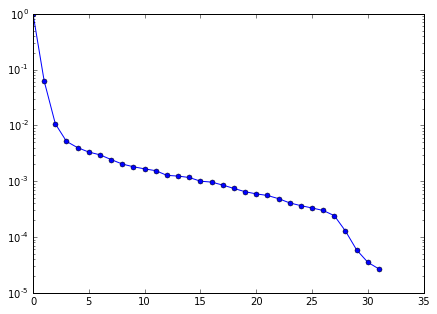

In [817]:
EE_spectrum = my_XXZ.EE(op_weights, L/2)[0]
plt.plot(EE_spectrum, marker='o', markersize=5.0)
plt.yscale('log')

In [827]:
W = 3.0
J = 1.0
Delta = 1.0
seed = 0

EE_vs_L = []
Ls = range(4, 13, 2)
for L in Ls:
    random_numbers = random_numbers_file[seed, :L]*W
    my_XXZ = XXZ(L, J, Delta, random_numbers)
    my_XXZ.create_matrix_block()
    my_XXZ.diagonalize()
    
    original_weights = my_XXZ.eigenvalues
    original_weights /= np.sqrt(sum(original_weights**2))
    
    EE_vs_L.append(my_XXZ.EE(original_weights, L/2-1)[1])
    
    print('Done L={}'.format(L))

Done L=4
Done L=6
Done L=8
Done L=10
Done L=12


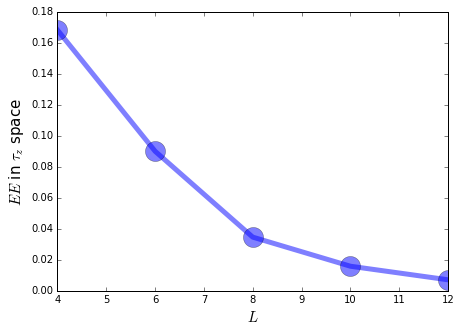

In [828]:
plt.plot(Ls, EE_vs_L, lw=5.0, marker='o', markersize=20., alpha=0.5)
plt.xlabel(r'$L$', fontsize=15)
plt.ylabel(r'$EE$ in $\tau_z$ space', fontsize=15)

In [29]:
L = 10
W = 3.5
RS = 0

reordered_U_file_name = '/media/bkcgroup/bvillaonga/mutual_information/bw_sample/my_IOM_WWF/python/reordered_U_matrices/reordered_U_L{}_W{}_RS{}.h5'.format(L, W, RS)
    
f = h5py.File(reordered_U_file_name, 'r')
fields = np.array(f['fields'])
reordered_U = {}
quality = {}
num_skips = {}
permutations_rowidx = {}
permutations_colidx = {}
for sector in sectors:
    key = 'sector{}'.format(sector)
    grp = f[key]
    reordered_U[sector] = np.array(grp['reordered_U'])
    quality[sector] = np.array(grp['quality'])
    num_skips[sector] = np.array(grp['num_skips'])
    permutations_rowidx[sector] = np.array(grp['permutations_rowidx'])
    permutations_colidx[sector] = np.array(grp['permutations_colidx'])

IOError: Unable to open file (Unable to open file: name = '/media/bkcgroup/bvillaonga/mutual_information/bw_sample/my_iom_wwf/python/reordered_u_matrices/reordered_u_l10_w3.5_rs0.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

## Implementation with strings

In [829]:
%matplotlib inline
import numpy as np
import scipy
import scipy.sparse as sparse
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)
import pandas as pd
import itertools as it
import os
import h5py

In [1235]:
L = 4
diag_string_from_idx = {}
offdiag_string_from_idx = {}
joint_string_from_idx = {}
diag_idx_from_string = {}
offdiag_idx_from_string = {}
joint_idx_from_string = {}

In [1236]:
ops = ['I', 'X', 'Y', 'Z']

count_diag = 0
count_offdiag = 0
count_joint = 0
for string in it.product(ops, repeat=L):
    if ('X' in string) or ('Y' in string): # offdiag
        offdiag_string_from_idx[count_offdiag] = string
        offdiag_idx_from_string[string] = count_offdiag
        count_offdiag += 1
    else: # diag
        diag_string_from_idx[count_diag] = string
        diag_idx_from_string[string] = count_diag
        count_diag += 1
    joint_string_from_idx[count_joint] = string
    joint_idx_from_string[string] = count_joint
    count_joint += 1

In [1279]:
offdiag_strings_two_sites = []
for s in joint_idx_from_string:
    #if s.count('X')+s.count('Y')==2 and s.count('Z')==0:
    #if s.count('X')+s.count('Y')==2:
    if True:
        offdiag_strings_two_sites.append(s)

In [1280]:
def product_of_ops(o1, o2):
    if o1=='I': return (1., o2)
    elif o2=='I': return (1., o1)
    elif o1=='X' and o2=='Y': return (1.j, 'Z')
    elif o1=='Y' and o2=='X': return (-1.j, 'Z')
    elif o1=='X' and o2=='Z': return (-1.j, 'Y')
    elif o1=='Z' and o2=='X': return (1.j, 'Y')
    elif o1=='Y' and o2=='Z': return (1.j, 'X')
    elif o1=='Z' and o2=='Y': return (-1.j, 'X')
    elif o1==o2: return(1., 'I')

In [1281]:
def product_of_strings(s1, s2):
    product_string = []
    factors = []
    for i in range(len(s1)):
        factor_op = product_of_ops(s1[i], s2[i])
        factors.append(factor_op[0])
        product_string.append(factor_op[1])
    factor = reduce(lambda x, y: x*y, factors)
    return (factor, tuple(product_string))

In [1214]:
L = 8
H_strings =  [('Z', 'I', 'I', 'I', 'I', 'I', 'I', 'I'), ('I', 'Z', 'I', 'I', 'I', 'I', 'I', 'I'), \
             ('I', 'I', 'Z', 'I', 'I', 'I', 'I', 'I'), ('I', 'I', 'I', 'Z', 'I', 'I', 'I', 'I'), \
             ('I', 'I', 'I', 'I', 'Z', 'I', 'I', 'I'), ('I', 'I', 'I', 'I', 'I', 'Z', 'I', 'I'), \
              ('I', 'I', 'I', 'I', 'I', 'I', 'Z', 'I'), ('I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z'), \
              ('X', 'Y', 'I', 'I', 'I', 'I', 'I', 'I'), ('Y', 'X', 'I', 'I', 'I', 'I', 'I', 'I'), \
              ('I', 'X', 'Y', 'I', 'I', 'I', 'I', 'I'), ('I', 'Y', 'X', 'I', 'I', 'I', 'I', 'I'), \
              ('I', 'I', 'X', 'Y', 'I', 'I', 'I', 'I'), ('I', 'I', 'Y', 'X', 'I', 'I', 'I', 'I'), \
              ('I', 'I', 'I', 'X', 'Y', 'I', 'I', 'I'), ('I', 'I', 'I', 'Y', 'X', 'I', 'I', 'I'), \
             ('I', 'I', 'I', 'I', 'X', 'Y', 'I', 'I'), ('I', 'I', 'I', 'I', 'Y', 'X', 'I', 'I'), \
             ('I', 'I', 'I', 'I', 'I', 'X', 'Y', 'I'), ('I', 'I', 'I', 'I', 'I', 'Y', 'X', 'I'), \
             ('I', 'I', 'I', 'I', 'I', 'I', 'X', 'Y'), ('I', 'I', 'I', 'I', 'I', 'I', 'Y', 'X')]

In [933]:
L = 8
H_strings =  [('I', 'I', 'Z', 'I', 'I', 'I', 'I', 'I'), ('I', 'X', 'Y', 'I', 'I', 'I', 'I', 'I'),\
              ('I', 'Y', 'X', 'I', 'I', 'I', 'I', 'I'), ('I', 'Z', 'I', 'I', 'I', 'I', 'I', 'I')]

In [1206]:
L = 8
H_strings =  [('X', 'Z', 'X', 'I', 'I', 'I', 'I', 'I')]

In [1106]:
L = 5
H_strings =  [('I', 'I', 'I', 'X', 'X')]

In [1364]:
L = 4
H_strings =  [('I', 'I', 'I', 'Z')]

In [1372]:
L = 4
H_strings =  [('Z', 'I', 'I', 'I'), ('I', 'Z', 'I', 'I'), ('I', 'I', 'Z', 'I'), ('I', 'I', 'I', 'Z'), \
             ('X', 'Y', 'I', 'I'), ('Y', 'X', 'I', 'I'), ('I', 'X', 'Y', 'I'), ('I', 'Y', 'X', 'I'), \
             ('I', 'I', 'X', 'Y'), ('I', 'I', 'Y', 'X')]

In [1373]:
H = np.zeros(len(joint_string_from_idx), dtype=complex)
for s in H_strings:
    H[joint_idx_from_string[s]] = 1.#np.random.rand()

In [1374]:
def sandwich_U_H_Ud(s, H, theta):
    new_H = np.array(H)
    factor = 1./(1.+theta**2.)
    for string in joint_idx_from_string:
        amplitude = H[joint_idx_from_string[string]]
        if abs(H[joint_idx_from_string[string]])>0.0:
            (factor1, string1) = product_of_strings(s, string)
            (factor2, string2) = product_of_strings(string, s)
            (factor3_partial, string3) = product_of_strings(string1, s)
            factor3 = factor3_partial*factor1
            new_H[joint_idx_from_string[string1]] += 1.j * theta * factor1 * amplitude
            new_H[joint_idx_from_string[string2]] -= 1.j * theta * factor2 * amplitude
            new_H[joint_idx_from_string[string3]] += theta**2. * factor3 * amplitude
    new_H *= factor
    return new_H

In [1367]:
new_H = sandwich_U_H_Ud(('I', 'I', 'X', 'X'), H, -0.5)

In [1368]:
sum(abs(new_H)**2)

1.0000000000000002

In [1369]:
sum(abs(H)**2)

1.0

In [1370]:
relevant_idx = np.array(range(len(joint_string_from_idx)))[abs(H)>0.0]
relevant_strings =  [joint_string_from_idx[idx] for idx in relevant_idx]
for string in relevant_strings:
    print string, ' -> ',  H[joint_idx_from_string[string]]

('I', 'I', 'I', 'Z')  ->  (1+0j)


In [1371]:
relevant_idx = np.array(range(len(joint_string_from_idx)))[abs(new_H)>0.0]
relevant_strings =  [joint_string_from_idx[idx] for idx in relevant_idx]
for string in relevant_strings:
    print string, ' -> ',  new_H[joint_idx_from_string[string]]

('I', 'I', 'I', 'Z')  ->  (0.6000000000000001+0j)
('I', 'I', 'X', 'Y')  ->  (-0.8+0j)


In [1300]:
relevant_idx = np.array(range(len(joint_string_from_idx)))[abs(H_prime)>0.0]
relevant_strings =  [joint_string_from_idx[idx] for idx in relevant_idx]
for string in relevant_strings:
    print string, ' -> ',  H_prime[joint_idx_from_string[string]]

('I', 'I', 'I', 'Z')  ->  (1.1890424234193298+0j)
('I', 'I', 'X', 'X')  ->  (-0.023020910629172414+0j)
('I', 'I', 'X', 'Y')  ->  (0.11578808004269464+0j)
('I', 'I', 'Y', 'X')  ->  (0.12540071672614972+0j)
('I', 'I', 'Y', 'Y')  ->  (0.1386764000351177+0j)
('I', 'I', 'Z', 'I')  ->  (1.6690079639894506+0j)
('I', 'I', 'Z', 'Z')  ->  (0.003801235656824171+0j)
('I', 'X', 'I', 'X')  ->  (0.15257732351581615+0j)
('I', 'X', 'I', 'Y')  ->  (0.032211623299952155+0j)
('I', 'X', 'X', 'I')  ->  (0.01045680116537756+0j)
('I', 'X', 'X', 'Z')  ->  (0.015995485108860022+0j)
('I', 'X', 'Y', 'I')  ->  (0.023186921237609785+0j)
('I', 'X', 'Y', 'Z')  ->  (-0.04429406197258774+0j)
('I', 'X', 'Z', 'X')  ->  (0.0800955968338064+0j)
('I', 'X', 'Z', 'Y')  ->  (0.05376136049482136+0j)
('I', 'Y', 'I', 'X')  ->  (0.14720981134688238+0j)
('I', 'Y', 'I', 'Y')  ->  (0.06000980756355745+0j)
('I', 'Y', 'X', 'I')  ->  (0.03075042070232048+0j)
('I', 'Y', 'X', 'Z')  ->  (-0.036728311286240475+0j)
('I', 'Y', 'Y', 'I')  ->  

In [1291]:
diag_amplitudes = []
for string in diag_idx_from_string:
    diag_amplitudes.append(H[joint_idx_from_string[string]])
sum(abs(np.array(diag_amplitudes))**2)

4.0

In [1292]:
diag_amplitudes = []
for string in diag_idx_from_string:
    diag_amplitudes.append(new_H[joint_idx_from_string[string]])
sum(abs(np.array(diag_amplitudes))**2)

2.7200000000000006

In [1293]:
succesive_strings = [('X', 'X', 'I', 'I', 'I', 'I', 'I', 'I'), ('I', 'X', 'X', 'I', 'I', 'I', 'I', 'I'), \
                       ('X', 'X', 'I', 'I', 'I', 'I', 'I', 'I'), ('I', 'I', 'I', 'X', 'X', 'I', 'I', 'I'), \
                    ('I', 'I', 'I', 'I', 'X', 'X', 'I', 'I'), ('I', 'I', 'I', 'I', 'I', 'X', 'X', 'I'), \
                    ('I', 'I', 'I', 'I', 'I', 'I', 'X', 'X'), \
                    ('X', 'Z', 'Y', 'I', 'I', 'I', 'I', 'I'), ('I', 'X', 'Z', 'Y', 'I', 'I', 'I', 'I'), \
                       ('I', 'I', 'X', 'Z', 'Y', 'I', 'I', 'I'), ('I', 'I', 'I', 'X', 'Z', 'Y', 'I', 'I'), \
                    ('I', 'I', 'I', 'I', 'X', 'Z', 'Y', 'I'), ('I', 'I', 'I', 'I', 'I', 'X', 'Z', 'Y')]

In [1375]:
actual_diag_weights = []
H_prime = H

In [1378]:
H_prime = np.array(H_prime)

thetas = np.linspace(-1., 1., 21)
diag_amplitudes = []
for string in diag_idx_from_string:
    diag_amplitudes.append(H_prime[joint_idx_from_string[string]])
actual_diag_weights.append(sum(abs(np.array(diag_amplitudes))**2))

#for t in succesive_strings:
for i in range(10000):
    #t = offdiag_strings_two_sites[np.random.randint(len(offdiag_strings_two_sites))]
    t = offdiag_strings_two_sites[i%len(offdiag_strings_two_sites)]
    print t
    diag_weights = []
    for theta in thetas:
        new_H = sandwich_U_H_Ud(t, H_prime, theta)
        diag_amplitudes = []
        for string in diag_idx_from_string:
            diag_amplitudes.append(new_H[joint_idx_from_string[string]])
        diag_weights.append(sum(abs(np.array(diag_amplitudes))**2))
    diag_weights = np.array(diag_weights)
    
    theta = thetas[np.argmax(diag_weights)]
    #if diag_weights[1]==diag_weights[2]: theta = np.random.rand()*2.-1.
    #if theta==0.: theta = (np.random.rand()*2.-1.)*0.01
    H_prime = sandwich_U_H_Ud(t, H_prime, theta)
    diag_amplitudes = []
    for string in diag_idx_from_string:
        diag_amplitudes.append(H_prime[joint_idx_from_string[string]])
    actual_diag_weights.append(sum(abs(np.array(diag_amplitudes))**2))

('X', 'X', 'Y', 'X')
('Z', 'Y', 'Z', 'I')
('I', 'X', 'X', 'I')
('I', 'Y', 'Z', 'Y')
('Y', 'Y', 'Y', 'I')
('I', 'X', 'Y', 'I')
('I', 'Z', 'I', 'Z')
('X', 'X', 'I', 'X')
('Y', 'Y', 'I', 'Z')
('X', 'X', 'X', 'Y')
('Y', 'Y', 'X', 'Y')
('I', 'X', 'X', 'Z')
('X', 'I', 'Y', 'Y')
('Y', 'Z', 'Y', 'Z')
('Y', 'Y', 'Y', 'X')
('I', 'Z', 'Y', 'Z')
('Y', 'Z', 'X', 'X')
('Z', 'Z', 'I', 'Y')
('X', 'I', 'Z', 'I')
('Y', 'I', 'Z', 'Y')
('Z', 'X', 'Z', 'I')
('I', 'Y', 'Z', 'X')
('I', 'Y', 'X', 'I')
('Y', 'Z', 'Y', 'X')
('Z', 'I', 'X', 'Y')
('Y', 'Y', 'Y', 'Z')
('Z', 'I', 'X', 'X')
('I', 'I', 'I', 'Y')
('I', 'Z', 'Y', 'I')
('X', 'I', 'Z', 'Z')
('I', 'I', 'Y', 'X')
('Z', 'X', 'Y', 'I')
('Y', 'Z', 'I', 'Z')
('Z', 'Y', 'Y', 'Y')
('Y', 'I', 'Y', 'I')
('I', 'X', 'I', 'Z')
('Z', 'I', 'Y', 'Y')
('X', 'Z', 'Y', 'Z')
('I', 'Z', 'X', 'I')
('Z', 'Z', 'I', 'Z')
('Y', 'I', 'X', 'I')
('X', 'X', 'Y', 'Z')
('I', 'I', 'Y', 'Y')
('Y', 'Z', 'I', 'I')
('Y', 'X', 'Y', 'Y')
('Y', 'Z', 'X', 'I')
('Y', 'Z', 'Z', 'I')
('X', 'Z', 'X

('Y', 'Y', 'X', 'Z')
('Z', 'X', 'Y', 'Z')
('I', 'X', 'Z', 'Z')
('I', 'I', 'I', 'I')
('Z', 'I', 'I', 'I')
('Z', 'X', 'X', 'I')
('X', 'X', 'Y', 'Y')
('I', 'Z', 'Z', 'X')
('X', 'I', 'Y', 'X')
('Z', 'I', 'Z', 'I')
('Y', 'Z', 'Y', 'Y')
('Y', 'Y', 'I', 'Y')
('I', 'I', 'X', 'X')
('I', 'I', 'I', 'Z')
('X', 'X', 'I', 'Y')
('X', 'Y', 'Z', 'X')
('I', 'Y', 'Y', 'X')
('X', 'I', 'X', 'Z')
('Z', 'Y', 'Z', 'X')
('Y', 'X', 'Y', 'X')
('Y', 'I', 'Z', 'X')
('I', 'Y', 'Y', 'Z')
('I', 'Z', 'Z', 'Y')
('X', 'Z', 'Z', 'Y')
('I', 'X', 'Y', 'Z')
('Z', 'Z', 'Z', 'Y')
('Y', 'I', 'Y', 'Z')
('X', 'Y', 'Y', 'I')
('Y', 'I', 'I', 'X')
('Y', 'Y', 'Z', 'Z')
('I', 'Y', 'I', 'X')
('Y', 'X', 'Y', 'Z')
('Y', 'X', 'Z', 'X')
('I', 'Y', 'I', 'Y')
('Z', 'Y', 'I', 'I')
('Y', 'Y', 'Z', 'I')
('Z', 'X', 'X', 'Z')
('I', 'X', 'I', 'Y')
('X', 'X', 'X', 'X')
('I', 'Y', 'I', 'Z')
('Y', 'Y', 'Z', 'X')
('I', 'I', 'Z', 'Y')
('I', 'Y', 'X', 'Z')
('Z', 'Y', 'Z', 'Z')
('I', 'Z', 'I', 'Y')
('Z', 'Y', 'Y', 'X')
('X', 'Z', 'Z', 'X')
('I', 'X', 'Y

('I', 'Z', 'Y', 'Z')
('Y', 'Z', 'X', 'X')
('Z', 'Z', 'I', 'Y')
('X', 'I', 'Z', 'I')
('Y', 'I', 'Z', 'Y')
('Z', 'X', 'Z', 'I')
('I', 'Y', 'Z', 'X')
('I', 'Y', 'X', 'I')
('Y', 'Z', 'Y', 'X')
('Z', 'I', 'X', 'Y')
('Y', 'Y', 'Y', 'Z')
('Z', 'I', 'X', 'X')
('I', 'I', 'I', 'Y')
('I', 'Z', 'Y', 'I')
('X', 'I', 'Z', 'Z')
('I', 'I', 'Y', 'X')
('Z', 'X', 'Y', 'I')
('Y', 'Z', 'I', 'Z')
('Z', 'Y', 'Y', 'Y')
('Y', 'I', 'Y', 'I')
('I', 'X', 'I', 'Z')
('Z', 'I', 'Y', 'Y')
('X', 'Z', 'Y', 'Z')
('I', 'Z', 'X', 'I')
('Z', 'Z', 'I', 'Z')
('Y', 'I', 'X', 'I')
('X', 'X', 'Y', 'Z')
('I', 'I', 'Y', 'Y')
('Y', 'Z', 'I', 'I')
('Y', 'X', 'Y', 'Y')
('Y', 'Z', 'X', 'I')
('Y', 'Z', 'Z', 'I')
('X', 'Z', 'X', 'I')
('X', 'Y', 'X', 'X')
('Z', 'Z', 'Y', 'I')
('X', 'X', 'I', 'Z')
('X', 'Y', 'Z', 'Y')
('I', 'X', 'X', 'X')
('Y', 'Z', 'X', 'Z')
('Y', 'I', 'I', 'I')
('X', 'I', 'I', 'Y')
('Y', 'Y', 'Z', 'Y')
('Y', 'X', 'X', 'I')
('I', 'I', 'X', 'I')
('I', 'I', 'Y', 'I')
('Z', 'X', 'Y', 'X')
('X', 'Z', 'I', 'I')
('X', 'X', 'Z

('I', 'Y', 'Y', 'X')
('X', 'I', 'X', 'Z')


KeyboardInterrupt: 

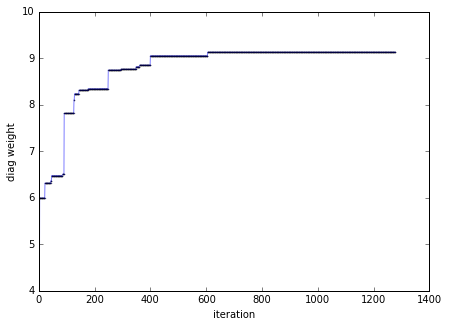

In [1379]:
plt.plot(actual_diag_weights, marker='o', markersize=1., alpha=0.5)
plt.xlabel('iteration')
plt.ylabel('diag weight')
#plt.ylim(4, 10)
#plt.xlim(-1, 200)

In [936]:
diag_weights = []
thetas = np.linspace(-2., 2., 21)
for theta in thetas:
    diag_amplitudes = []
    new_H = sandwich_U_H_Ud(('I', 'X', 'X', 'I', 'I', 'I', 'I', 'I'), H, theta)
    for string in diag_idx_from_string:
        diag_amplitudes.append(new_H[joint_idx_from_string[string]])
    diag_weights.append(sum(abs(np.array(diag_amplitudes))**2))

(-0.1, 10.1)

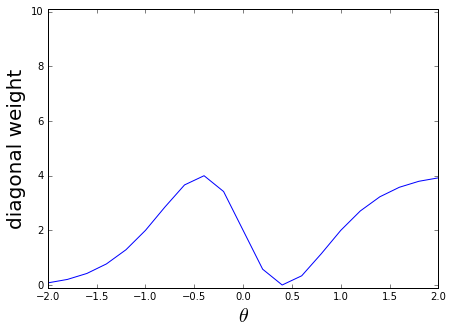

In [937]:
plt.plot(thetas, diag_weights)
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('diagonal weight', fontsize=20)
plt.ylim(-0.1, 10.1)

In [666]:
num_points = 21
diag_weights_2D = np.zeros((num_points, num_points))
thetas = np.linspace(-2., 2., num_points)
rhos = np.linspace(-2., 2., num_points)
for i, theta in enumerate(thetas):
    new_H = sandwich_U_H_Ud(('I', 'I', 'X', 'X', 'I', 'I', 'I', 'I'), H, theta)
    for j, rho in enumerate(rhos):
        new_new_H = sandwich_U_H_Ud(('I', 'X', 'X', 'I', 'I', 'I', 'I', 'I'), new_H, rho)
        diag_amplitudes = []
        for string in diag_idx_from_string:
            diag_amplitudes.append(new_new_H[joint_idx_from_string[string]])
        diag_weight = sum(abs(np.array(diag_amplitudes))**2)
        diag_weights_2D[i, j] = diag_weight

In [ ]:
plt.imshow(diag_weights_2D, interpolation='None')
plt.colorbar()
plt.savefig('two_step_landscape.pdf', )